In [2]:
from importlib import reload
import time
import joblib
from pylab import *
from tqdm import tqdm

import sys
sys.path.append("..")

from helper_basic import *
import helper_basic as hp
import helper_finetime as hpt
import helper_visa as vs

import config
reload(vs)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<module 'helper_visa' from '/home/mathusla/tofpet/Mu-Hardware/Keysight/../helper_visa.py'>

# Step 1: connect to the scope and set parameters
- If you don't know the address, do vs.connect()
- Otherwise, put the address in the argument will speed it up

In [3]:
path = config.scope
scope = vs.connect(address = "TCPIP0::192.168.1.23::inst0::INSTR", timeout=30_000) # set 30 second
# vs.disconnect(scope)

Connected to VISA [TCPIP0::192.168.1.23::inst0::INSTR]:  KEYSIGHT TECHNOLOGIES,EXR054A,MY63160110,11.50.00201



In [47]:
###################################################################
### SET THESE PARAMETERS before moving on
###################################################################


# Filename to save data
filename_save = config.scope+"coincidence_preamp_v5/18_old_bar_cosmic.joblib"
# filename_save = config.scope+"pulse_shape/preamp_v5b_B_sipm_calibration_averaged.joblib"

# Trigger channel ** channel number start from 1!
trigger_channel = None
# Channels to readout
read_channel = [1,2,3,4]
# Trace length
acquire_length = 4096


# Software coincidence trigger
trigger_and = True
trigger_and_channel = 3
trigger_and_threshold = 0.04
trigger_and_trys = 30

# Example 1: read the current waveform from the scope

- For simplicity of the code and better readout speed, please configure the trigger threshold and channel setup on the scope

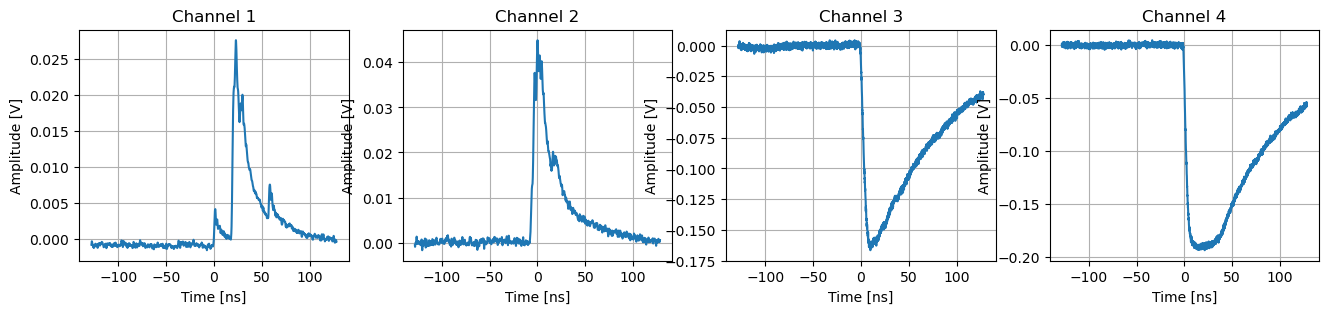

In [40]:
# data,time_series=read_waveform_cuts(scope, trigger_channel = trigger_channel, read_channel = read_channel, acquire_length = acquire_length, calibrate = True, initialize = True, calibration_data=None)
data,time_series=vs.read_waveform(scope, trigger_channel = trigger_channel, read_channel = read_channel, \
                                  acquire_length = acquire_length, calibrate = True, initialize = True, calibration_data=None,\
                                    trigger_and = trigger_and, trigger_and_channel = trigger_and_channel, trigger_and_threshold = trigger_and_threshold, trigger_and_trys=trigger_and_trys)


fig,axs= subplots(1, len(read_channel), figsize=(4*len(read_channel),3))
for i in range(len(read_channel)):
    sca(axs[i])
    ch = read_channel[i]
    plot(time_series*1e9, data[ch])

    title(f"Channel {ch}")
    xlabel("Time [ns]")
    ylabel("Amplitude [V]")
    grid()

# Example 2: repetitively read multiple waveforms from the scope

- For simplicity of the code and better readout speed, please configure the trigger threshold and channel setup on the scope

1/10 events acquired, time elapsed 1.9 s, time from last print 1.9 s
2/10 events acquired, time elapsed 20.2 s, time from last print 18.3 s
3/10 events acquired, time elapsed 28.2 s, time from last print 8.1 s
4/10 events acquired, time elapsed 34.1 s, time from last print 5.9 s
5/10 events acquired, time elapsed 35.1 s, time from last print 0.9 s
6/10 events acquired, time elapsed 57.6 s, time from last print 22.5 s
7/10 events acquired, time elapsed 65.7 s, time from last print 8.1 s
8/10 events acquired, time elapsed 87.6 s, time from last print 21.9 s
9/10 events acquired, time elapsed 110.6 s, time from last print 23.1 s
10/10 events acquired, time elapsed 127.5 s, time from last print 16.9 s


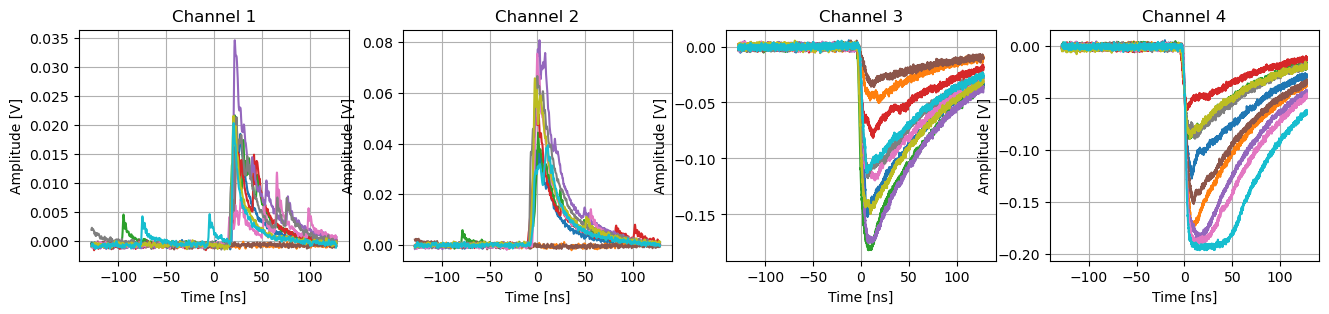

In [48]:
N_events = 10
print_every_n = 1
N_plot = N_events


data_save = vs.get_events(scope, Nevents = N_events, print_every_n = print_every_n, \
                          trigger_channel = trigger_channel, read_channel = read_channel, \
                            acquire_length = acquire_length, calibrate = True,\
                        trigger_and = trigger_and, trigger_and_channel = trigger_and_channel, trigger_and_threshold = trigger_and_threshold, trigger_and_trys=trigger_and_trys)



time_series = data_save["metadata"]["time_series"]
fig,axs= subplots(1, len(read_channel), figsize=(4*len(read_channel),3))
for i in range(len(read_channel)):
    sca(axs[i])
    ch = read_channel[i]

    for j in range(N_plot):
        plot(time_series*1e9, data_save[ch][j])

    title(f"Channel {ch}")
    xlabel("Time [ns]")
    ylabel("Amplitude [V]")
    grid()

# Acquire the data

In [28]:
N_events = 9000
print_every_n = N_events//10


data_save = vs.get_events(scope, Nevents = N_events, print_every_n = print_every_n, \
                          trigger_channel = trigger_channel, read_channel = read_channel, \
                            acquire_length = acquire_length, calibrate = True,\
                        trigger_and = trigger_and, trigger_and_channel = trigger_and_channel, trigger_and_threshold = trigger_and_threshold, trigger_and_trys=trigger_and_trys)



joblib.dump(data_save, filename_save,compress =False)


900/9000 events acquired, time elapsed 20.4 s, time from last print 20.4 s
1800/9000 events acquired, time elapsed 41.6 s, time from last print 21.2 s
2700/9000 events acquired, time elapsed 61.7 s, time from last print 20.0 s
3600/9000 events acquired, time elapsed 82.0 s, time from last print 20.3 s
4500/9000 events acquired, time elapsed 102.4 s, time from last print 20.4 s
5400/9000 events acquired, time elapsed 121.8 s, time from last print 19.4 s
6300/9000 events acquired, time elapsed 141.4 s, time from last print 19.7 s
7200/9000 events acquired, time elapsed 161.5 s, time from last print 20.0 s
8100/9000 events acquired, time elapsed 181.7 s, time from last print 20.2 s
9000/9000 events acquired, time elapsed 202.3 s, time from last print 20.7 s


['/mnt/sda2//scope_data/coincidence_preamp_v5/14_LED_calib_-0.1V.joblib']

In [49]:
# Split into multiple files
nfiles = 1
N_events = 250
print_every_n = N_events//10


for iscan in range(0, nfiles):
  print("----------------------------------------------")
  print(f"Acquiring file {iscan+1}/{nfiles}:")

  data_save = vs.get_events(scope, Nevents = N_events, print_every_n = print_every_n, \
                            trigger_channel = trigger_channel, read_channel = read_channel, \
                              acquire_length = acquire_length, calibrate = True,\
                          trigger_and = trigger_and, trigger_and_channel = trigger_and_channel, trigger_and_threshold = trigger_and_threshold, trigger_and_trys=trigger_and_trys)

  filename_save = os.path.splitext(filename_save)[0]+f"_{iscan}.joblib"
  print(filename_save)

  joblib.dump(data_save, filename_save,compress =False) 

----------------------------------------------
Acquiring file 1/1:
25/250 events acquired, time elapsed 379.1 s, time from last print 379.1 s
50/250 events acquired, time elapsed 659.4 s, time from last print 280.4 s
75/250 events acquired, time elapsed 1049.6 s, time from last print 390.2 s
100/250 events acquired, time elapsed 1337.2 s, time from last print 287.6 s
125/250 events acquired, time elapsed 1624.3 s, time from last print 287.1 s
150/250 events acquired, time elapsed 1973.9 s, time from last print 349.6 s
175/250 events acquired, time elapsed 2328.0 s, time from last print 354.2 s
200/250 events acquired, time elapsed 2664.3 s, time from last print 336.3 s
225/250 events acquired, time elapsed 2961.5 s, time from last print 297.2 s
250/250 events acquired, time elapsed 3352.2 s, time from last print 390.7 s
